In [7]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!pip install pydot
!rm -rf ./logs/ 

/Users/samholt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Regression with Keras

So far we have mainly looked at the digits dataset, which is a classification problem with *Keras*, however it is also easy to create a regression model, we simply change the output to a single `tf.keras.layers.Dense` layer with one unit and no activation function. This outputs a scalar value that is unbounded, and is the sum of the weighted inputs from the previous layer.

I.e. a model of the form

In [155]:
from tensorflow import keras

units = 64

model = keras.Sequential([
    keras.layers.Dense(units, activation='relu', input_shape=[1]),
    keras.layers.Dense(units, activation='relu'),
    keras.layers.Dense(1)
])

We can train such a model on a toy dataset, i.e. the 

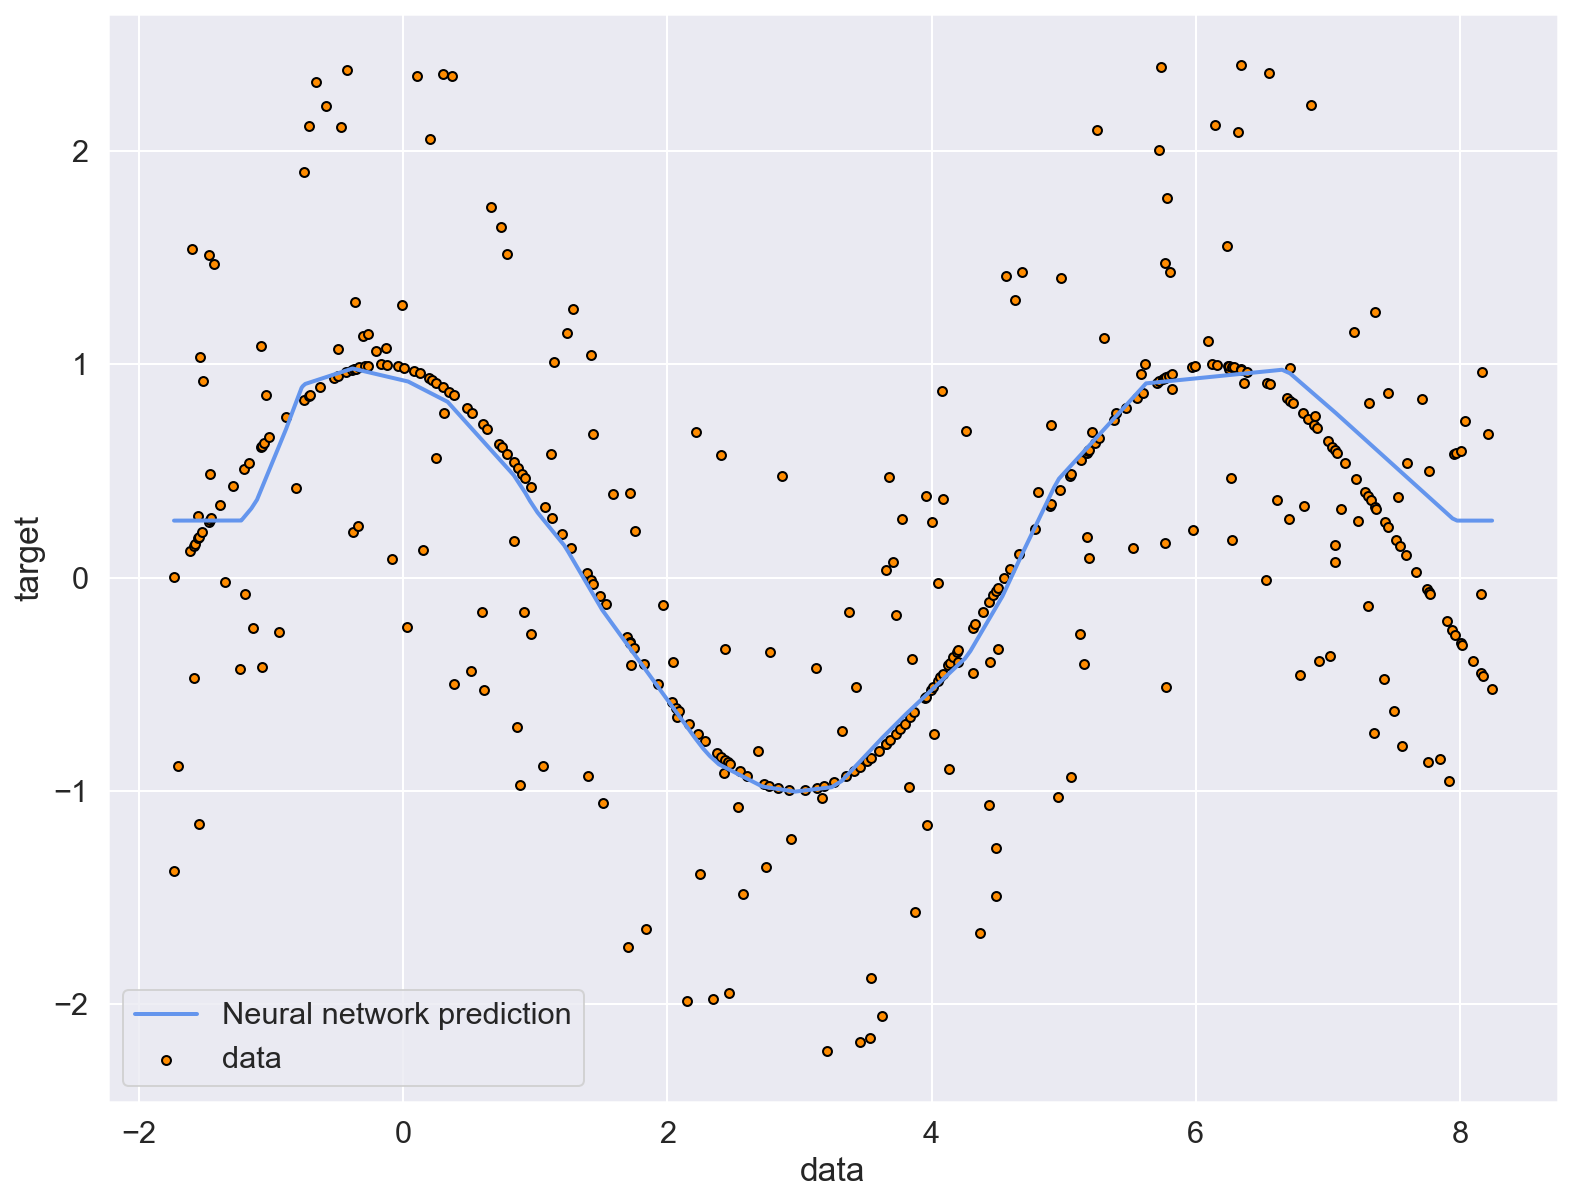

In [156]:
from sklearn.model_selection import train_test_split

# Create a dataset of a sinusoid with noise
x_range = 10.0
noise_for_each = 2
rng = np.random.RandomState(1)
X = np.sort(x_range * rng.rand(400, 1), axis=0)
y = np.sin(X).ravel()
y[::noise_for_each] += 3 * (0.5 - rng.rand(len(y[::noise_for_each])))

# Standardise the inputs (Can help the NN with training)
X = (X - X.mean() / X.std())

X = X.astype(np.float32)
y = y.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Compile the regression model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(loss='mae',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

# Train the regression model
history = model.fit(X_train, y_train, epochs=301,
                    verbose=0, validation_split=0.2)

# Predict
X_test = np.arange(X.min(), X.max(), 0.001)[:, np.newaxis].astype(np.float32)
y_test = model.predict(X_test)

# Plot the results
plt.figure(figsize=(13, 10))
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_test, color="cornflowerblue",
         label="Neural network prediction", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.legend()
plt.show()

We can visualise the models training metrics over each epoch by the attributes of the `history` object

In [157]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,0.979650,0.979650,1.591414,0.664278,0.664278,0.660421,0
1,0.711494,0.711493,0.778038,0.657403,0.657403,0.658108,1
2,0.705464,0.705464,0.748381,0.619380,0.619380,0.586597,2
3,0.655878,0.655878,0.696412,0.585788,0.585788,0.559315,3
4,0.645877,0.645877,0.680295,0.585066,0.585066,0.564192,4
...,...,...,...,...,...,...,...
296,0.419046,0.419046,0.387251,0.476033,0.476033,0.441396,296
297,0.413396,0.413396,0.376648,0.509111,0.509111,0.470966,297
298,0.421559,0.421559,0.375534,0.449394,0.449394,0.423948,298
299,0.413811,0.413811,0.377919,0.447337,0.447337,0.414381,299


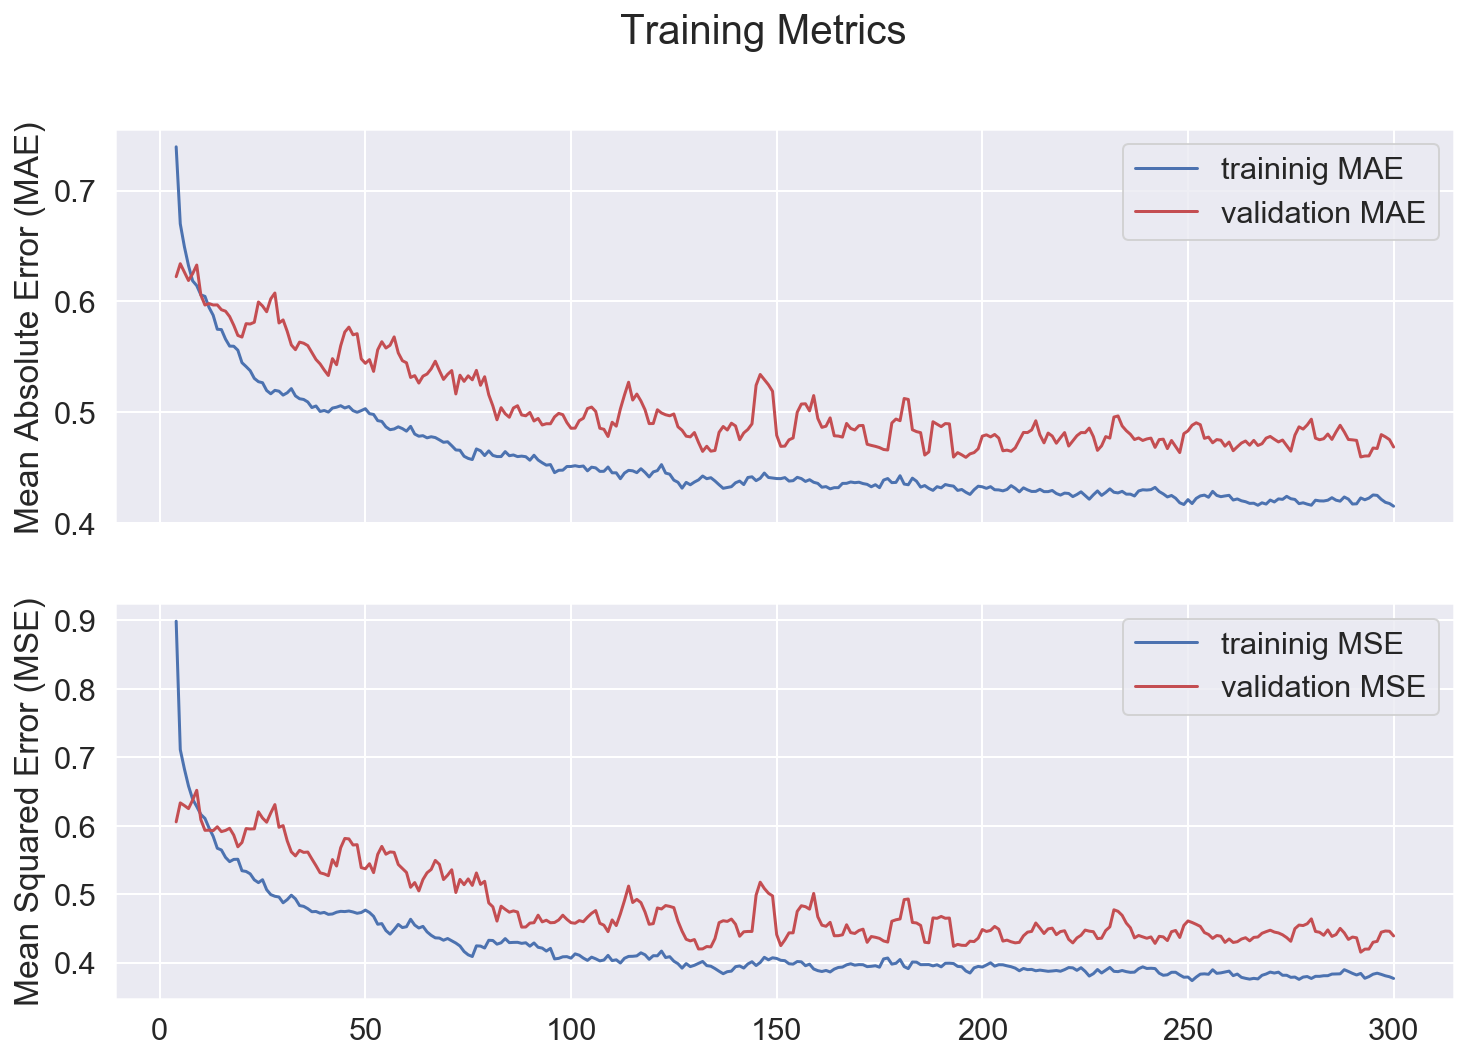

In [158]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

epochs_to_mean = 5

axes[0].set_ylabel("Mean Absolute Error (MAE)")
axes[0].plot(history_df['mae'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_mae'].rolling(epochs_to_mean).mean(), '-r')
axes[0].legend(['traininig MAE', 'validation MAE'])

axes[1].set_ylabel("Mean Squared Error (MSE)")
axes[1].plot(history_df['mse'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_mse'].rolling(epochs_to_mean).mean(), '-r')
axes[1].legend(['traininig MSE', 'validation MSE'])
plt.show()

In [43]:
history.

SyntaxError: invalid syntax (<ipython-input-43-a9dc7e2fff28>, line 1)


## Regularisers really before this ! 

## Optomisers !

## Normalisation techniques

## Maybe fine tuning some of the neural network parameters and discussion about these here


---

# Training deep neurla netowrks ! - Vanishing & Exploding gradients problems



# Artificial neural networks (ANN)

Will have to do a video on Tensorboard at some point

Optomizers

Activation functions

Initilisation schemes etc

Dropout etc ! 